In [38]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt


In [39]:
nifty_df9 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-24-03-2015-to-15-03-2016.csv')
nifty_df1 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-16-03-2016-to-16-03-2017.csv')
nifty_df2 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-17-03-2017-to-17-03-2018.csv')
nifty_df3 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-18-03-2018-to-18-03-2019.csv')
nifty_df4 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-19-03-2019-to-19-03-2020.csv')
nifty_df5 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-20-03-2020-to-20-03-2021.csv')
nifty_df6 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-21-03-2021-to-21-03-2022.csv')
nifty_df7 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-22-03-2022-to-22-03-2023.csv')
nifty_df8 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-23-03-2023-to-23-03-2024.csv')
nifty_df10 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-24-03-2024-to-24-03-2025.csv')


In [3]:
data = pd.concat([nifty_df9,nifty_df1,nifty_df2,nifty_df3,nifty_df4,nifty_df5,nifty_df6,nifty_df7,nifty_df8,nifty_df10], axis=0, ignore_index=True)

In [4]:
data = data.dropna()

In [5]:
data.tail()

,Date,Open,High,Low,Close,Shares Traded,Turnover (₹ Cr)
2473,17-MAR-2025,22353.15,22577.0,22353.15,22508.75,251102239.0,24122.27
2474,18-MAR-2025,22662.25,22857.8,22599.20,22834.30,272578844.0,26387.47
2475,19-MAR-2025,22874.95,22940.7,22807.95,22907.60,323992121.0,26994.95
2476,20-MAR-2025,23036.60,23216.7,22973.95,23190.65,313729818.0,27573.99
2477,21-MAR-2025,23168.25,23402.7,23132.80,23350.40,540966316.0,51005.67


In [6]:
data.columns

Index(['Date ', 'Open ', 'High ', 'Low ', 'Close ', 'Shares Traded ',
       'Turnover (₹ Cr)'],
      dtype='object')

In [7]:
high = data['High ']
low = data['Low ']
close = data['Close ']
open = data['Open ']


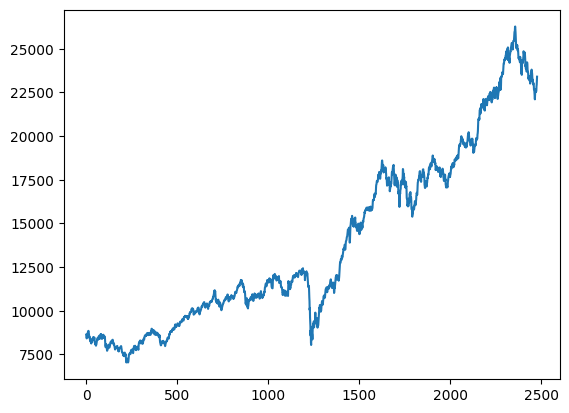

In [8]:
plt.plot(high)

In [9]:
data = data.drop(columns=['Date '])
data.columns = data.columns.str.strip()


##Data preprocessing

In [10]:
from sklearn.preprocessing import MinMaxScaler

In [11]:
scaler = MinMaxScaler()

# Fit and transform the full dataset
scaled_data = scaler.fit_transform(data.values)

# Convert back to DataFrame if needed
scaled_df = pd.DataFrame(scaled_data, columns=data.columns)

In [12]:
def create_multivariate_dataset(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])      # shape: (look_back, num_features)
        y.append(data[i+look_back])        # shape: (num_features,)
    return np.array(X), np.array(y)


In [13]:
look_back = 10
X, y = create_multivariate_dataset(scaled_data, look_back)


In [14]:
from sklearn.model_selection import train_test_split
import torch
from torch.utils.data import DataLoader, TensorDataset
import numpy as np

# Assuming X and y are already created using the sliding window approach
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, shuffle=False
)

X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)


#GRU and Analysis

In [15]:
import torch.nn as nn

class GRUNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(GRUNet, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.gru = nn.GRU(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.gru(x, h0)
        return self.fc(out[:, -1, :])


In [16]:
input_size = X.shape[2]        # Number of features
hidden_size = 64
num_layers = 2
output_size = y.shape[1]       # Same as input_size if predicting all features

model = GRUNet(input_size, hidden_size, num_layers, output_size)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

num_epochs = 50

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        output = model(batch_x)
        loss = criterion(output, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / len(train_loader):.4f}")


Epoch [1/50], Loss: 0.0137
Epoch [2/50], Loss: 0.0016
Epoch [3/50], Loss: 0.0012
Epoch [4/50], Loss: 0.0012
Epoch [5/50], Loss: 0.0011
Epoch [6/50], Loss: 0.0011
Epoch [7/50], Loss: 0.0012
Epoch [8/50], Loss: 0.0011
Epoch [9/50], Loss: 0.0011
Epoch [10/50], Loss: 0.0010
Epoch [11/50], Loss: 0.0011
Epoch [12/50], Loss: 0.0010
Epoch [13/50], Loss: 0.0010
Epoch [14/50], Loss: 0.0010
Epoch [15/50], Loss: 0.0010
Epoch [16/50], Loss: 0.0010
Epoch [17/50], Loss: 0.0010
Epoch [18/50], Loss: 0.0010
Epoch [19/50], Loss: 0.0010
Epoch [20/50], Loss: 0.0010
Epoch [21/50], Loss: 0.0010
Epoch [22/50], Loss: 0.0010
Epoch [23/50], Loss: 0.0009
Epoch [24/50], Loss: 0.0009
Epoch [25/50], Loss: 0.0010
Epoch [26/50], Loss: 0.0009
Epoch [27/50], Loss: 0.0010
Epoch [28/50], Loss: 0.0010
Epoch [29/50], Loss: 0.0010
Epoch [30/50], Loss: 0.0009
Epoch [31/50], Loss: 0.0009
Epoch [32/50], Loss: 0.0010
Epoch [33/50], Loss: 0.0009
Epoch [34/50], Loss: 0.0009
Epoch [35/50], Loss: 0.0009
Epoch [36/50], Loss: 0.0010
E

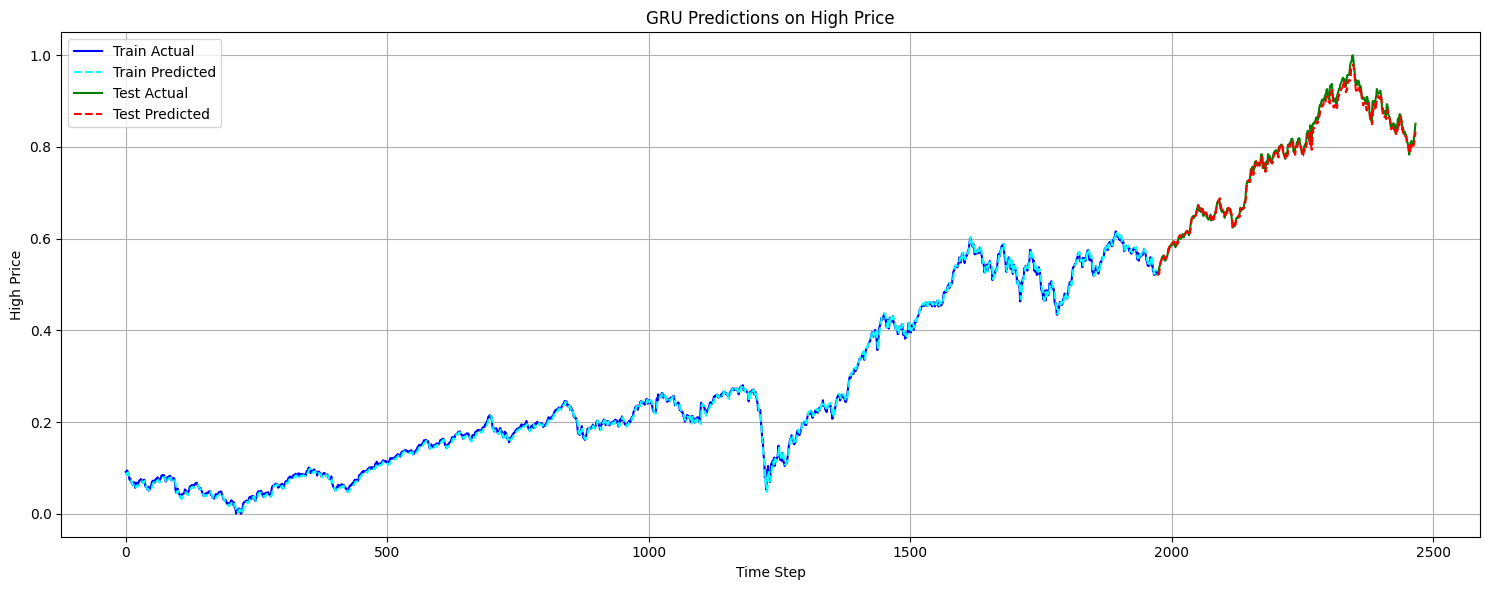

In [17]:
model.eval()
with torch.no_grad():
    train_preds = model(X_train_tensor).cpu().numpy()
    test_preds = model(X_test_tensor).cpu().numpy()

y_train_np = y_train_tensor.cpu().numpy()
y_test_np = y_test_tensor.cpu().numpy()

import matplotlib.pyplot as plt

# feature_idx = 3  # For example, 'Close' column

feature_idx=1 #for high
plt.figure(figsize=(15, 6))

# Plot training
plt.plot(y_train_np[:, feature_idx], label='Train Actual', color='blue')
plt.plot(train_preds[:, feature_idx], label='Train Predicted', color='cyan', linestyle='--')

# Plot testing
plt.plot(range(len(y_train_np), len(y_train_np) + len(y_test_np)),
         y_test_np[:, feature_idx], label='Test Actual', color='green')
plt.plot(range(len(y_train_np), len(y_train_np) + len(y_test_np)),
         test_preds[:, feature_idx], label='Test Predicted', color='red', linestyle='--')

plt.xlabel('Time Step')
plt.ylabel('High Price')
plt.title('GRU Predictions on High Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [18]:
from sklearn.metrics import mean_squared_error

# Make predictions
model.eval()
with torch.no_grad():
    train_preds = model(torch.tensor(X_train, dtype=torch.float32)).numpy()
    test_preds = model(torch.tensor(X_test, dtype=torch.float32)).numpy()

# Select only the 'High' feature (assumed index 1)
y_train_high = y_train[:, 1]
y_test_high = y_test[:, 1]

train_preds_high = train_preds[:, 1]
test_preds_high = test_preds[:, 1]

# Compute MSE
train_mse_high = mean_squared_error(y_train_high, train_preds_high)
test_mse_high = mean_squared_error(y_test_high, test_preds_high)

print(f"Train MSE for High: {train_mse_high:.6f}")
print(f"Test MSE for High: {test_mse_high:.6f}")


Train MSE for High: 0.000035
Test MSE for High: 0.000104


In [24]:
from sklearn.metrics import mean_absolute_percentage_error

# Assuming you have the scaler used to scale the data, e.g., `scaler` for MinMaxScaler or StandardScaler
# Inverse transform the predictions and actual values to the original scale
y_train_high_unscaled = scaler.inverse_transform(y_train)[:, 1]
y_test_high_unscaled = scaler.inverse_transform(y_test)[:, 1]

train_preds_high_unscaled = scaler.inverse_transform(train_preds)[:, 1]
test_preds_high_unscaled = scaler.inverse_transform(test_preds)[:, 1]

# Compute MAPE
train_mape_high = mean_absolute_percentage_error(y_train_high_unscaled, train_preds_high_unscaled)
test_mape_high = mean_absolute_percentage_error(y_test_high_unscaled, test_preds_high_unscaled)

print(f"Train MAPE for High: {100*train_mape_high:.6f}")
print(f"Test MAPE for High: {100*test_mape_high:.6f}")


Train MAPE for High: 0.753151
Test MAPE for High: 0.641174


#GRU with Attention

In [40]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


In [41]:
nifty_df9 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-24-03-2015-to-15-03-2016.csv')
nifty_df1 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-16-03-2016-to-16-03-2017.csv')
nifty_df2 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-17-03-2017-to-17-03-2018.csv')
nifty_df3 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-18-03-2018-to-18-03-2019.csv')
nifty_df4 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-19-03-2019-to-19-03-2020.csv')
nifty_df5 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-20-03-2020-to-20-03-2021.csv')
nifty_df6 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-21-03-2021-to-21-03-2022.csv')
nifty_df7 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-22-03-2022-to-22-03-2023.csv')
nifty_df8 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-23-03-2023-to-23-03-2024.csv')
nifty_df10 = pd.read_csv('/content/drive/MyDrive/MTH443 Project/NIFTY 50-24-03-2024-to-24-03-2025.csv')


In [42]:
data = pd.concat([nifty_df9,nifty_df1,nifty_df2,nifty_df3,nifty_df4,nifty_df5,nifty_df6,nifty_df7,nifty_df8,nifty_df10], axis=0, ignore_index=True)

In [43]:
data = data.dropna()

In [44]:
data = data.drop(columns=['Date '])
data.columns = data.columns.str.strip()


In [45]:
# Normalize
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(data.values)

# Convert to tensor
data = torch.tensor(scaled_data, dtype=torch.float32)


In [46]:
def create_dataset(data, look_back=10):
    X, y = [], []
    for i in range(len(data) - look_back):
        X.append(data[i:i+look_back])
        y.append(data[i+look_back])
    return torch.stack(X), torch.stack(y)

look_back = 10
X, y = create_dataset(data, look_back)


In [47]:
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]


In [48]:
class GRUWithAttention(nn.Module):
    def __init__(self, input_size, hidden_dim, output_size):
        super(GRUWithAttention, self).__init__()
        self.gru = nn.GRU(input_size, hidden_dim, batch_first=True)
        self.attn = nn.Linear(hidden_dim, 1)
        self.fc = nn.Linear(hidden_dim, output_size)

    def forward(self, x, return_attention=False):
        gru_out, _ = self.gru(x)  # [batch, seq_len, hidden_dim]
        attn_weights = torch.softmax(self.attn(gru_out), dim=1)  # [batch, seq_len, 1]
        context = torch.sum(attn_weights * gru_out, dim=1)  # [batch, hidden_dim]
        output = self.fc(context)  # [batch, output_size]
        if return_attention:
            return output, attn_weights.squeeze(-1)  # shape: [batch, seq_len]
        return output


In [49]:
input_dim = X.shape[2]
hidden_dim = 64
output_dim = y.shape[1]

model = GRUWithAttention(input_dim, hidden_dim, output_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

n_epochs = 500


In [50]:
for epoch in range(n_epochs):
    model.train()
    optimizer.zero_grad()
    output = model(X_train)
    loss = criterion(output, y_train)
    loss.backward()
    optimizer.step()

    if epoch % 10 == 0:
        print(f'Epoch {epoch}, Loss: {loss.item():.5f}')


Epoch 0, Loss: 0.09198
Epoch 10, Loss: 0.03353
Epoch 20, Loss: 0.01332
Epoch 30, Loss: 0.01050
Epoch 40, Loss: 0.00700
Epoch 50, Loss: 0.00454
Epoch 60, Loss: 0.00362
Epoch 70, Loss: 0.00336
Epoch 80, Loss: 0.00304
Epoch 90, Loss: 0.00286
Epoch 100, Loss: 0.00268
Epoch 110, Loss: 0.00251
Epoch 120, Loss: 0.00232
Epoch 130, Loss: 0.00212
Epoch 140, Loss: 0.00191
Epoch 150, Loss: 0.00171
Epoch 160, Loss: 0.00154
Epoch 170, Loss: 0.00142
Epoch 180, Loss: 0.00137
Epoch 190, Loss: 0.00135
Epoch 200, Loss: 0.00134
Epoch 210, Loss: 0.00133
Epoch 220, Loss: 0.00132
Epoch 230, Loss: 0.00132
Epoch 240, Loss: 0.00131
Epoch 250, Loss: 0.00130
Epoch 260, Loss: 0.00130
Epoch 270, Loss: 0.00130
Epoch 280, Loss: 0.00129
Epoch 290, Loss: 0.00129
Epoch 300, Loss: 0.00128
Epoch 310, Loss: 0.00128
Epoch 320, Loss: 0.00128
Epoch 330, Loss: 0.00127
Epoch 340, Loss: 0.00127
Epoch 350, Loss: 0.00127
Epoch 360, Loss: 0.00126
Epoch 370, Loss: 0.00126
Epoch 380, Loss: 0.00126
Epoch 390, Loss: 0.00125
Epoch 400, 

In [51]:
# Set model to eval mode
model.eval()

# Get test predictions and attention weights
with torch.no_grad():
    pred_test, attn_weights_test = model(X_test_tensor, return_attention=True)


In [52]:
from sklearn.metrics import mean_squared_error
model.eval()
pred_train = model(X_train).detach().numpy()
pred_test = model(X_test).detach().numpy()
# Use index 1 for 'High' feature
train_mse_high = mean_squared_error(y_train[:, 1].numpy(), pred_train[:, 1])
test_mse_high = mean_squared_error(y_test[:, 1].numpy(), pred_test[:, 1])

print(f"Train MSE on Normalized High: {train_mse_high:.6f}")
print(f"Test MSE on Normalized High: {test_mse_high:.6f}")


Train MSE on Normalized High: 0.000152
Test MSE on Normalized High: 0.001174


In [53]:
from sklearn.metrics import mean_absolute_percentage_error

# Reverse the scaling for both actual and predicted values using the scaler
# Assuming you have the scaler object available (e.g., `scaler` for MinMaxScaler or StandardScaler)
y_train_high_unscaled = scaler.inverse_transform(y_train)[:, 1]
y_test_high_unscaled = scaler.inverse_transform(y_test)[:, 1]

pred_train_high_unscaled = scaler.inverse_transform(pred_train)[:, 1]
pred_test_high_unscaled = scaler.inverse_transform(pred_test)[:, 1]

# Compute MAPE for unscaled data
train_mape_high = mean_absolute_percentage_error(y_train_high_unscaled, pred_train_high_unscaled)
test_mape_high = mean_absolute_percentage_error(y_test_high_unscaled, pred_test_high_unscaled)

print(f"Train MAPE on Unscaled High: {100*train_mape_high:.6f}")
print(f"Test MAPE on Unscaled High: {100*test_mape_high:.6f}")


Train MAPE on Unscaled High: 0.014636
Test MAPE on Unscaled High: 0.023552


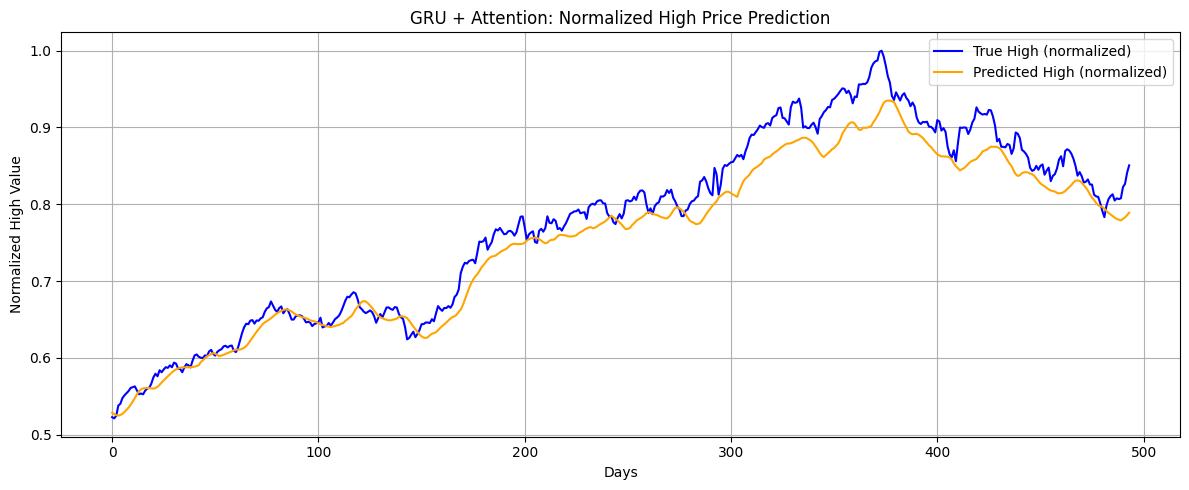

In [ ]:
import matplotlib.pyplot as plt

# Extract only the 'High' feature (index 1)
true_high = y_test[:, 1].numpy()
pred_high = pred_test[:, 1]

plt.figure(figsize=(12, 5))
plt.plot(true_high, label='True High (normalized)', color='blue')
plt.plot(pred_high, label='Predicted High (normalized)', color='orange')
plt.title('GRU + Attention: Normalized High Price Prediction')
plt.xlabel('Days')
plt.ylabel('Normalized High Value')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


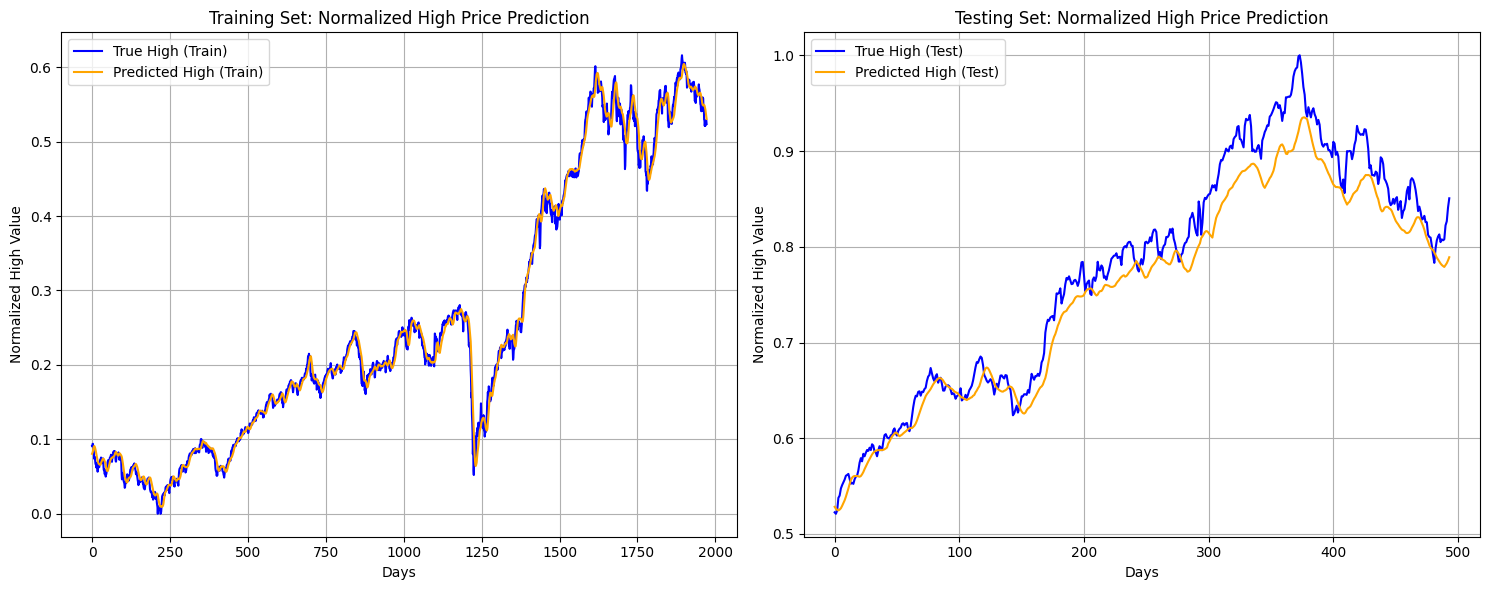

In [ ]:
import matplotlib.pyplot as plt

# Extract 'High' feature (index 1)
train_true_high = y_train[:, 1].numpy()
train_pred_high = pred_train[:, 1]

test_true_high = y_test[:, 1].numpy()
test_pred_high = pred_test[:, 1]

# Plotting
plt.figure(figsize=(15, 6))

# Training set
plt.subplot(1, 2, 1)
plt.plot(train_true_high, label='True High (Train)', color='blue')
plt.plot(train_pred_high, label='Predicted High (Train)', color='orange')
plt.title('Training Set: Normalized High Price Prediction')
plt.xlabel('Days')
plt.ylabel('Normalized High Value')
plt.legend()
plt.grid(True)

# Testing set
plt.subplot(1, 2, 2)
plt.plot(test_true_high, label='True High (Test)', color='blue')
plt.plot(test_pred_high, label='Predicted High (Test)', color='orange')
plt.title('Testing Set: Normalized High Price Prediction')
plt.xlabel('Days')
plt.ylabel('Normalized High Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


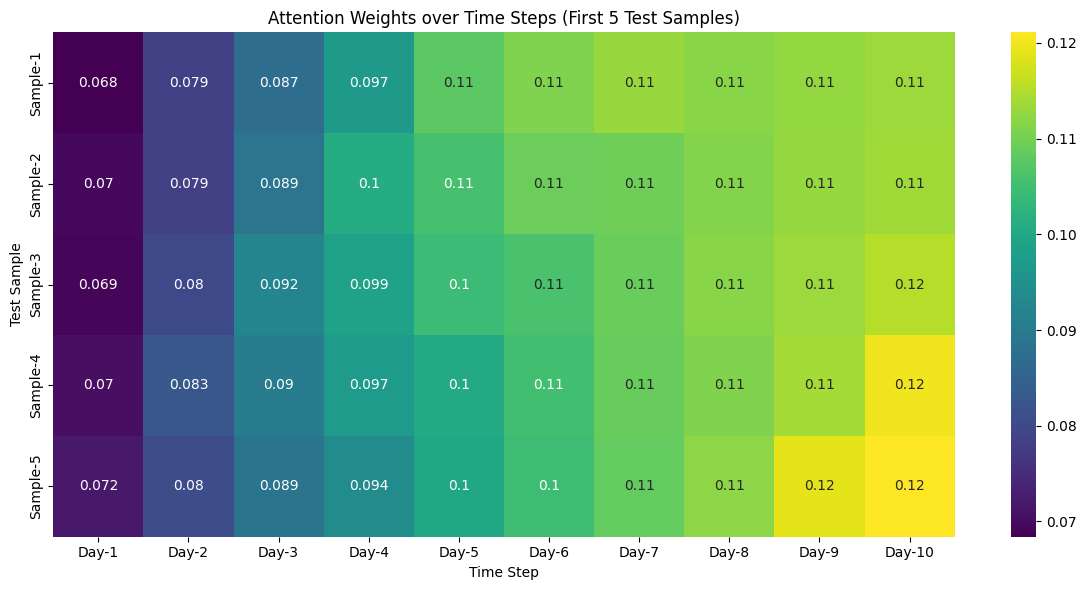

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot attention weights for first 5 samples in the test set
num_samples = 5
plt.figure(figsize=(12, 6))

# Prepare the attention weights matrix: shape (num_samples, sequence_length)
attn_matrix = attn_weights_test[:num_samples].cpu().numpy()

# Create the heatmap
sns.heatmap(attn_matrix, annot=True, cmap='viridis', xticklabels=[f"Day-{i+1}" for i in range(attn_matrix.shape[1])],
            yticklabels=[f"Sample-{i+1}" for i in range(num_samples)])

plt.title("Attention Weights over Time Steps (First 5 Test Samples)")
plt.xlabel("Time Step")
plt.ylabel("Test Sample")
plt.tight_layout()
plt.show()
